# $F=2 \rightarrow F'=3$ 1D molasses 

This example covers calculating the forces in a one-dimensional optical molasses
using the optical bloch equations.  It attempts to reproduce several figures 
from Ungar, P. J., Weiss,
D. S., Riis, E., & Chu, S. "Optical molasses and multilevel atoms:
theory." *Journal of the Optical Society of America B*, **6** 2058 (1989).
http://doi.org/10.1364/JOSAB.6.002058

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pylcp
import scipy.constants as cts
from pylcp.common import progressBar
import lmfit
savefigs = False

## Define the problem

Unager, *et. al.* focus on sodium, so we first find the mass parameter for $^{23}$Na:

In [2]:
atom = pylcp.atom('23Na')
mass = (atom.state[2].gamma*atom.mass)/(cts.hbar*(100*2*np.pi*atom.transition[1].k)**2)
print(mass)

195.87538720801354


As with all other examples, we need to define the Hamiltonian, lasers, and magnetic field.  Here, we will write methods to return the Hamiltonian and the lasers in order to sweep their parameters.  Note that the magnetic field is always zero, so we define it as such.  Lastly, we make a dictionary of different polarizations that we will explore in this example.

In [3]:
def return_hamiltonian(Fl, Delta):
    Hg, Bgq = pylcp.hamiltonians.singleF(F=Fl, gF=0, muB=1)
    He, Beq = pylcp.hamiltonians.singleF(F=Fl+1, gF=1/(Fl+1), muB=1)
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(Fl, (Fl+1))
    hamiltonian = pylcp.hamiltonian(Hg, -Delta*np.eye(He.shape[0])+He, Bgq, Beq, dijq, mass=mass)
    
    return hamiltonian

# Now, make 1D laser beams:
def return_lasers(delta, beta, pol):
    if pol[0][2]>0 or pol[0][1]>0:
        pol_coord = 'spherical'
    else:
        pol_coord = 'cartesian'

    return pylcp.laserBeams([
        {'kvec':np.array([0., 0., 1.]), 'pol':pol[0],
         'pol_coord':pol_coord, 'delta':delta, 'beta':beta},
        {'kvec':np.array([0., 0., -1.]), 'pol':pol[1],
         'pol_coord':pol_coord, 'delta':delta, 'beta':beta},
        ], beam_type=pylcp.infinitePlaneWaveBeam)

magField = pylcp.constantMagneticField(np.array([0., 0., 0.]))

# Now make a bunch of polarization keys:
pols = {'$\\sigma^+\\sigma^-$':[np.array([0., 0., 1.]), np.array([1., 0., 0.])],
        '$\\sigma^+\\sigma^+$':[np.array([0., 0., 1.]), np.array([0., 0., 1.])]}
    
phi = [0, np.pi/4, np.pi/2]
phi_keys = ['$\phi=0$', '$\phi=\pi/4$', '$\phi=\pi/2$']
for phi_i, key_beam in zip(phi, phi_keys):
        pols[key_beam] = [np.array([1., 0., 0.]), np.array([np.cos(phi_i), np.sin(phi_i), 0.])]

## Make a basic force profile

This is not contained in Ungar, *et. al.*, but it makes a nice figure that contains most 
of the essential elements thereof.  We start by creating, using our functions defined above,
a set of lasers, the Hamiltonian, and then the set of optical Bloch equations for each polarization
specified in the dictionary defined above.

In [4]:
det = -2.5
beta = 1.0

hamiltonian = return_hamiltonian(2, det)

v = np.concatenate((np.arange(0.001, 0.01, 0.001),
                    np.arange(0.01, 0.1, 0.01),
                    np.arange(0.1, 5.1, 0.1)))

obe = {}
for key_beam in pols:
    laserBeams = return_lasers(0., beta, pol=pols[key_beam])

    obe[key_beam] = pylcp.obe(
        laserBeams, magField, hamiltonian,
        include_mag_forces=False, transform_into_re_im=True
    )
    
    obe[key_beam].generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_v=4, deltat_tmax=2*np.pi*5000, itermax=1000,
        rel=1e-8, abs=1e-10, progress_bar=True
    )

Completed in 6:46.                                                  
Completed in 3:07.                                                  
Completed in 7:32.                                                  
Completed in 7:42.                                                  
Completed in 7:42.                                                  
Completed in 8:11.                                                  
Completed in 8:20.                                                  


Plot it up:

'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


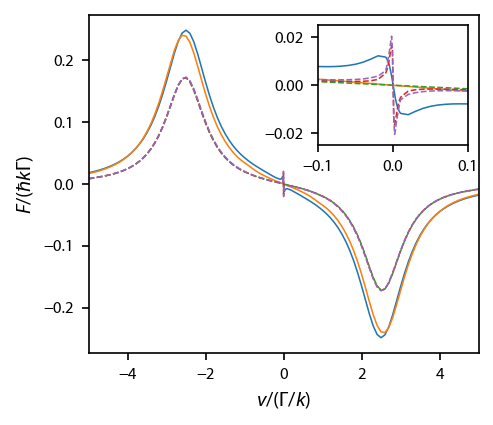

In [21]:
fig, ax = plt.subplots(1, 1)
axins = inset_axes(ax, width=1.0, height=0.8)
for key in obe:
    if 'phi' in key:
        linestyle='--'
    else:
        linestyle='-'

    ax.plot(np.concatenate((-v[::-1], v)),
            np.concatenate((-obe[key].profile['molasses'].F[2][::-1],
                            obe[key].profile['molasses'].F[2])),
            label=pols[key], linestyle=linestyle,
            linewidth=0.75
            )
    axins.plot(np.concatenate((-v[::-1], v)),
               np.concatenate((-obe[key].profile['molasses'].F[2][::-1],
                               obe[key].profile['molasses'].F[2])),
            label=pols[key], linestyle=linestyle,
            linewidth=0.75
            )
    
ax.set_xlim(-5, 5)    
ax.set_xlabel('$v/(\Gamma/k)$')
ax.set_ylabel('$F/(\hbar k \Gamma)$')
axins.set_xlim(-0.1, 0.1)
axins.set_ylim(-0.025, 0.025)
#axins.set_ylabel('$10^3 F/\hbar k \Gamma$', fontsize=8)
if savefigs:
    fig.savefig('F2_to_F3_subDoppler_force.pdf')

## Reproduce various figures
### Figure 6

This figure compares the force for various polarizations.  To make it, we first make each OBE individually, and save the resulting forces.
Note that in Ungar, *et. al.*, they define their velocity scale through $m v_0^2 = \hbar\Gamma$, resulting in forces in terms of $M v_0 \Gamma$.  Compared to us, they measure their velocities in terms of

$$
\frac{v_0}{k/\Gamma} = \sqrt{\frac{\hbar\Gamma}{m}}\frac{k}{\Gamma} =  \sqrt{\frac{\hbar k^2}{\Gamma m}} = \sqrt{\bar{m}}
$$

Likewise, the force ratio,

$$
\frac{M v_0 \Gamma}{\hbar k \Gamma} = \frac{M\sqrt{\hbar\Gamma}}{\hbar k} = \sqrt{\frac{M\Gamma}{\hbar k^2}} = \sqrt{\bar{m}}
$$

In [6]:
det = -2.73
beta = 1.25

v = np.concatenate((np.array([0.0]), np.logspace(-2, np.log10(4), 20)))/np.sqrt(mass)

keys_of_interest = ['$\\sigma^+\\sigma^+$', '$\\sigma^+\\sigma^-$',
                    '$\phi=0$', '$\phi=\pi/2$']

F = {}
for key in keys_of_interest:
    laserBeams = return_lasers(0., beta, pol=pols[key])
    hamiltonian = return_hamiltonian(2, det)

    obe = pylcp.obe(laserBeams, magField, hamiltonian,
                    transform_into_re_im=True)

    obe.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*1000, deltat_v=4, itermax=10,
        progress_bar=True
    )
    
    F[key] = obe.profile['molasses'].F[2]

Completed in 15:06.                                                 
Completed in 7:06.                                                  
Completed in 14:32.                                                 
Completed in 11:22.                                                 


Plot it up.

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


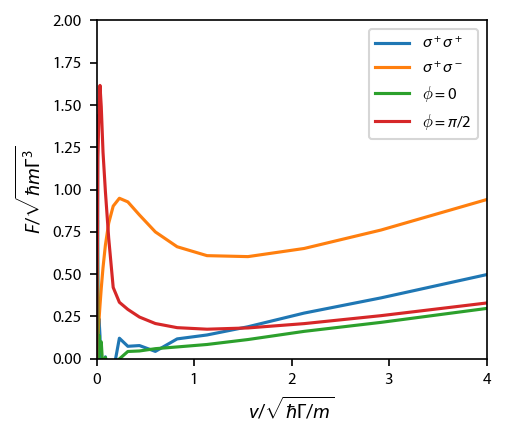

In [7]:
fig, ax = plt.subplots(1, 1, num="Forces; F=2 to F=3")
for key in keys_of_interest:
    ax.plot(v*np.sqrt(mass), -1e3*F[key]/np.sqrt(mass), label=key)
ax.set_xlabel('$v/\sqrt{\hbar\Gamma/m}$')
ax.set_ylabel('$F/\sqrt{\hbar m \Gamma^3}$')
ax.legend(fontsize=8)
ax.set_xlim((0, 4.))
ax.set_ylim((0, 2.))

if savefigs:
    fig.savefig('ungar_fig_6.pdf')

### Figure 7

Compare the two-level vs. the corkscrew at large velocities.

In [8]:
v = np.concatenate((np.arange(0, 1.5, 0.2),
                    np.arange(0.2, 50., 1.5)))/np.sqrt(mass)

beta = 1.25
det = -2.73

keys_of_interest = ['$\\sigma^+\\sigma^+$', '$\\sigma^+\\sigma^-$']

F = {}
for key in keys_of_interest:
    laserBeams = return_lasers(0., beta, pol=pols[key])
    hamiltonian = return_hamiltonian(2, det)
    
    obe = pylcp.obe(laserBeams, magField, hamiltonian,
                    transform_into_re_im=True)

    obe.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*100, deltat_v=4, itermax=1000,
        progress_bar=True
    )
    
    F[key] = obe.profile['molasses'].F[2]

Completed in 12:07.                                                 
Completed in 3:00.                                                  


Plot it up

'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


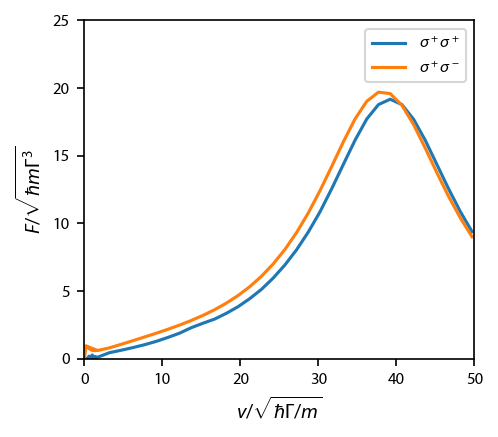

In [9]:
fig, ax = plt.subplots(1, 1)
for key in keys_of_interest:
    ax.plot(v*np.sqrt(mass), -1e3*F[key]/np.sqrt(mass), label=key)
ax.set_xlabel('$v/\sqrt{\hbar\Gamma/m}$')
ax.set_ylabel('$F/\sqrt{\hbar m \Gamma^3}$')
ax.set_ylim((0, 25))
ax.set_xlim((0, 50))
ax.legend(fontsize=8)

if savefigs:
    fig.savefig('ungar_fig_7.pdf')

### Figure 8

We run the detuning and saturation parameter for the corkscrew model.

In [10]:
dets = [-1.0, -1.37, -2.73]
betas = [0.5, 1.25, 2.5]
key = '$\\sigma^+\\sigma^-$'

v = np.arange(0.0, 1.025, 0.025)/np.sqrt(mass)
F_dets = [None]*3
for ii, det in enumerate(dets):
    laserBeams = return_lasers(0., betas[1], pol=pols[key])
    hamiltonian = return_hamiltonian(2, det)

    obe = pylcp.obe(laserBeams, magField, hamiltonian)

    obe.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*100, deltat_v=4, itermax=1000,
        progress_bar=True
    )
    
    F_dets[ii] = obe.profile['molasses'].F[2]

F_betas = [None]*3
for ii, beta in enumerate(betas):
    laserBeams = return_lasers(0., beta, pol=pols[key])
    hamiltonian = return_hamiltonian(2, dets[-1])

    obe = pylcp.obe(laserBeams, magField, hamiltonian)

    obe.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*100, deltat_v=4, itermax=1000,
        progress_bar=True
    )

    F_betas[ii] = obe.profile['molasses'].F[2]

Completed in 1:03.                                                  
Completed in 1:20.                                                  
Completed in 4:43.                                                  
Completed in 6:55.                                                  
Completed in 4:46.                                                  
Completed in 2:44.                                                  


Plot it up:

'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


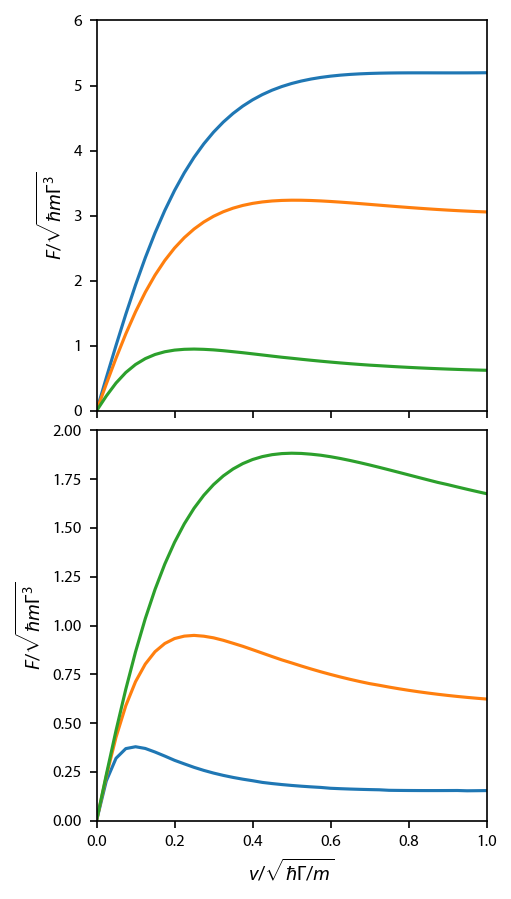

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(3.25, 2*2.75))
for (F, det) in zip(F_dets, dets):
    ax[0].plot(v*np.sqrt(mass), -1e3*F/np.sqrt(mass), label='$\delta = %f' % det)
for (F, beta) in zip(F_betas, betas):
    ax[1].plot(v*np.sqrt(mass), -1e3*F/np.sqrt(mass), label='$\beta = %f' % beta)
ax[1].set_xlabel('$v/\sqrt{\hbar\Gamma/m}$')
ax[0].set_ylabel('$F/\sqrt{\hbar m \Gamma^3}$')
ax[0].set_ylim((0, 6))
ax[0].set_xlim((0, 1))
ax[1].set_ylabel('$F/\sqrt{\hbar m \Gamma^3}$')
ax[1].set_ylim((0, 2))
ax[1].set_xlim((0, 1))

ax[0].xaxis.set_ticklabels('')

fig.subplots_adjust(bottom=0.01, hspace=0.05)

if savefigs:
    fig.savefig('ungar_fig_8.pdf')

## Simulate many atoms and find the temperature:

We start with just a single atom just to make sure everything is OK.

In [12]:
tmax = 1e4
det = -2.73
beta = 1.25
key =  '$\\sigma^+\\sigma^-$'

laserBeams = return_lasers(0., beta, pol=pols[key])
hamiltonian = return_hamiltonian(2, det)

obe = pylcp.obe(laserBeams, magField, hamiltonian,
                include_mag_forces=False)
    
obe.set_initial_position(np.array([0., 0., 0.]))
obe.set_initial_velocity(np.array([0., 0., 0.]))
obe.set_initial_rho_equally()

obe.evolve_motion(
    [0, tmax],
    t_eval=np.linspace(0, tmax, 501),
    random_recoil=True,
    progress_bar=True,
    max_scatter_probability=0.5,
    record_force=True,
    freeze_axis=[True, True, False]
)

Completed in 31.72 s.                                                


Plot up the test simulation:

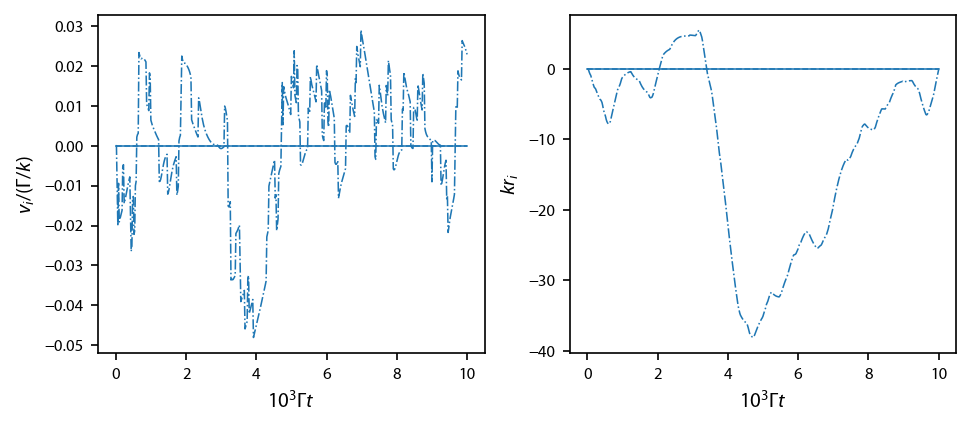

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 2.75))
ll = 0
styles = ['-', '--', '-.']
for jj in range(3):
    ax[0].plot(obe.sol.t/1e3,
               obe.sol.v[jj], styles[jj],
               color='C%d'%ll, linewidth=0.75)
    ax[1].plot(obe.sol.t/1e3,
               obe.sol.r[jj],
               styles[jj], color='C%d'%ll, linewidth=0.75)

#ax[1].set_ylim(-5., 5.)
ax[0].set_ylabel('$v_i/(\Gamma/k)$')
ax[1].set_ylabel('$k r_i$')
ax[0].set_xlabel('$10^{3} \Gamma t$')
ax[1].set_xlabel('$10^{3} \Gamma t$')
fig.subplots_adjust(left=0.1, wspace=0.22)

Now run a large sim with 96 atoms:

Non-parallel version:
    
```
sols = []
for jj in range(Natoms):
    trap.set_initial_position(np.array([0., 0., 100.]))
    trap.set_initial_velocity(0.0*np.random.randn(3))
    
    trap.evolve_motion([0, 3e2], 
                       t_eval=np.linspace(0, 1e2, 1001),
                       random_recoil=True,
                       recoil_velocity=v_R,
                       progress_bar=True,
                       max_scatter_probability=0.5,
                       record_force=True)
    
    sols.append(copy.copy(trap.sol))
```

Parallel version using `pathos`:

In [14]:
import pathos
if hasattr(obe, 'sol'):
    del obe.sol
    
t_eval = np.linspace(0, tmax, 5001)

def generate_random_solution(x, tmax=1e4):
    # We need to generate random numbers to prevent solutions from being seeded
    # with the same random number.
    np.random.rand(256*x)
    obe.set_initial_position(np.array([0., 0., 0.]))
    obe.set_initial_velocity(np.array([0., 0., 0.]))
    obe.set_initial_rho_equally()
    obe.evolve_motion(
        [0, tmax],
        t_eval=t_eval,
        random_recoil=True,
        max_scatter_probability=0.5,
        record_force=True,
        freeze_axis=[True, True, False]
    )
    
    return obe.sol

Natoms = 96
chunksize = 4
sols = []
progress = progressBar()
for jj in range(int(Natoms/chunksize)):
    with pathos.pools.ProcessPool(nodes=4) as pool:
        sols += pool.map(generate_random_solution, range(chunksize))
    progress.update((jj+1)/int(Natoms/chunksize))

Completed in 13:09.                                                 


Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/steve/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/steve/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/Users/steve/opt/anaconda3/lib/python3.7/site-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/Users/steve/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/steve/opt/anaconda3/lib/python3.7/site-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/Users/steve/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File

Now, plot all 96 trajectories:

'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


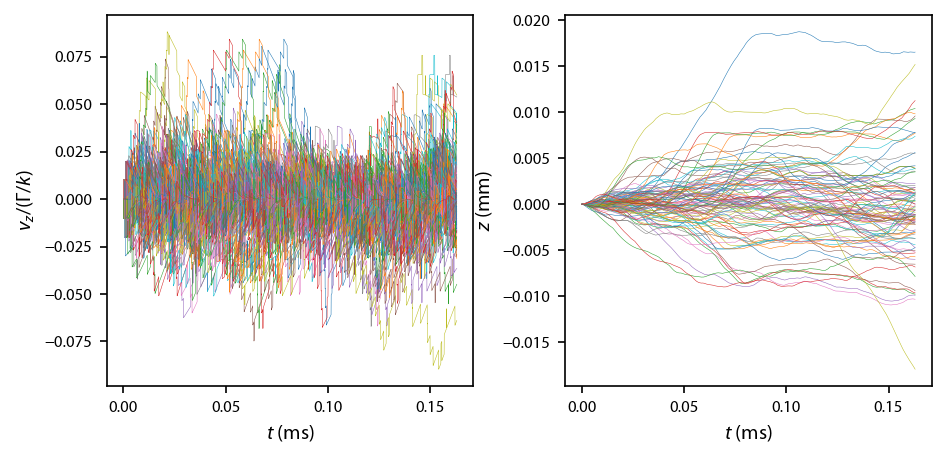

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(6.25, 2.75))

for sol in sols:
    ax[0].plot(sol.t*atom.state[1].tau*1e3,
               sol.v[2], linewidth=0.25)
    ax[1].plot(sol.t*atom.state[1].tau*1e3,
               sol.r[2]/(2*np.pi*0.1*atom.transition[1].k), linewidth=0.25)

for ax_i in ax:
    ax_i.set_xlabel('$t$ (ms)')
ax[0].set_ylabel('$v_z/(\Gamma/k)$')
ax[1].set_ylabel('$z$ (mm)')
    
fig.subplots_adjust(left=0.1, bottom=0.08, wspace=0.25)
if savefigs:
    fig.savefig('random_dynamics_F2_to_F3_molasses.pdf')

One interesting result from the Unager paper is to look at the average force as a function of position and velocity for the random particles.

'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


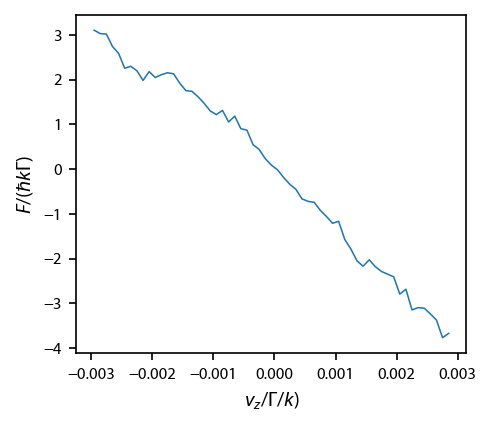

In [16]:
allv = np.concatenate([sol.v.T for sol in sols]).T
allF = np.concatenate([sol.F.T for sol in sols]).T

v = np.arange(-.003, 0.003, 0.0001)
vc = v[:-1]+np.mean(np.diff(v))/2

avgFv = np.zeros((3, 3, vc.size))
stdFv = np.zeros((3, 3, vc.size))

for jj in range(3):
    for ii, (v_l, v_r) in enumerate(zip(v[:-1],v[1:])):
        inds = np.bitwise_and(allv[jj] <= v_r, allv[jj] > v_l)
        if np.sum(inds)>0:
            for kk in range(3):
                avgFv[kk, jj, ii] = np.mean(allF[kk, inds])
                stdFv[kk, jj, ii] = np.std(allF[kk, inds])
        else:
            avgFv[:, jj, ii] = np.nan
            avgFv[:, jj, ii] = np.nan
                          
fig, ax = plt.subplots(1, 1)
ax.plot(vc, 1e3*avgFv[2, 2], linewidth=0.75)
ax.set_xlabel('$v_z/\Gamma/k)$')
ax.set_ylabel('$F/(\hbar k \Gamma)$')

if savefigs:
    fig.savefig('forces_experienced_random_evolution_F1_to_F2_obe.pdf')

Let's evaluate the temperature as a function of time:

'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Temperature 31.19 uK


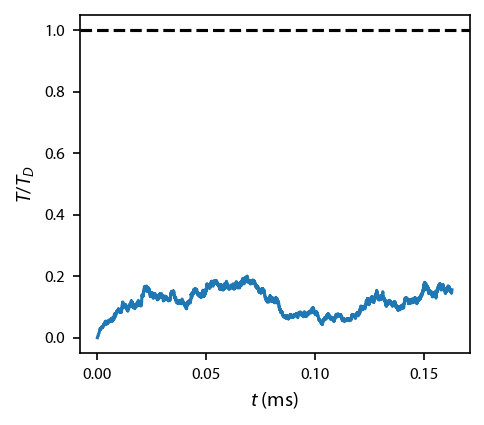

In [17]:
vs = np.nan*np.zeros((3, len(sols), len(t_eval)))
for ii, sol in enumerate(sols):
    vs[:, ii, :] = sol.v
    
sigma_v = np.std(vs[2], axis=0)

fig, ax = plt.subplots(1, 1)
ax.plot(t_eval*atom.state[1].tau*1e3, 2*sigma_v.T**2*hamiltonian.mass)
ax.axhline(1, color='k', linestyle='--')
ax.set_ylabel('$T/T_D$')
ax.set_xlabel('$t$ (ms)')

if savefigs:
    fig.savefig('temperature_dynamics_F2_to_F3.pdf')
    
print('Temperature %.2f uK' % (np.mean(2*sigma_v[-1000:]**2*hamiltonian.mass)*cts.hbar*atom.state[2].gamma/2/cts.k*1e6))

Now, let's bin the final data and fit it the histogram to extract the temperature.

'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


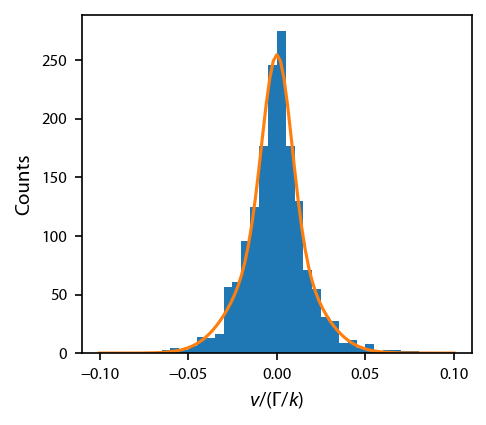

In [33]:
xb = np.arange(-0.1, 0.1, 0.005)
fig, ax = plt.subplots(1, 1)
ax.hist(vs[2, :, 1000::250].flatten(), bins=xb)
x = xb[:-1] + np.diff(xb)/2
y = np.histogram(vs[2, :, 1000::250].flatten(), bins=xb)[0]

model = lmfit.models.GaussianModel(prefix='A_') + lmfit.models.GaussianModel(prefix='B_')

params = model.make_params()
params['A_sigma'].value = 0.05
params['B_sigma'].value = 0.01

ok = y>0
result = model.fit(y[ok], params, x=x[ok], weights=1/np.sqrt(y[ok]))

x_fit = np.linspace(-0.1, 0.1, 101)
ax.plot(x_fit, result.eval(x=x_fit))
ax.set_xlabel('$v/(\Gamma/k)$')
ax.set_ylabel('Counts')

if savefigs:
    fig.savefig('temperature_histogram_F2_to_F3.pdf')

Print the best fit model results:

In [39]:
print(2*result.best_values['A_sigma']**2*mass*cts.hbar*atom.state[2].gamma/2/cts.k*1e6)
print(4*result.params['A_sigma'].stderr*result.params['A_sigma'].value*mass*cts.hbar*atom.state[2].gamma/2/cts.k*1e6)
#print(2*result.best_values['B_sigma']**2*mass*cts.hbar*atom.state[2].gamma/2/cts.k*1e6)
result

6.197412632767436
1.5794270273297655
